# A Python HMM Framework

We define two implicit interfaces, `Problem` and `Solver`.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')
import typing
from typing import List

class Problem:
    def __init__(self, *args, **kwargs):
        pass
    
    def get_data(self):
        """Return problem data."""
        pass
    
    def set_data(self, data):
        """Set problem data"""
        pass
    
    def is_solution(self, sol) -> bool:
        """Check if sol is solution """
        pass

        
class Solver:
    def __init__(self, *args, **kwargs):
        pass
    
    def can_solve(self, problem: Problem) -> bool:
        """Return True if solver can solve this problem."""
        pass
    
    def solve(self, problem: Problem, *args, **kwargs):
        pass

These instances will be used to build an HMM problem. We need two interfaces, `MicroProblem` and `MacroProblem`, and two classes, `HMMProblem` and `IterativeHMMSolver`. 

In [2]:
class MicroProblem(Problem):
    def update(self, macro: Problem):
        """Update micro problem with macro data"""
        pass

    
class MacroProblem(Problem): 
    def update(self, micros: List[Problem]):
        """Update macro problem with micro data"""
        pass
        
        
class HMMProblem(Problem):
    def __init__(self, macro: MacroProblem, micros: List[MicroProblem], *args, **kwargs):
        """Given a macro problem and a micro problem(s), construct a HMM solver."""
        self.macro = macro
        self.micros = micros
        pass
        
    def update_macro(self, micro_sols):
        self.macro.update(micro_sols)
        pass
    
    def update_micros(self, macro_sol):
        for macro in self.micros:
            macro.update(macro_sol)
        pass
    
    def update(self, macro_sol, micro_sols):
        self.update_macro(micro_sols)
        self.update_micros(macro_sol)
        pass
    
    def get_data(self, *args, **kwargs):
        return (self.macro.get_data(*args, **kwargs),) + tuple(micro.get_data(*args, **kwargs) for micro in self.micros)
    
    
    def set_data(self, macro_data, micro_datas, *args, **kwargs):
        self.macro.set_data(macro_data, *args, **kwargs)
        for micro, data in zip(self.micros, micro_datas):
            micro.set_data(data, *args, **kwargs)
        pass
    
    
    def is_solution(self, macro_sol, micro_sols, *args, **kwargs):
        """Check if solution"""
        self.update(macro_sol, micro_sols)
        return self.macro.is_solution(macro_sol, *args, **kwargs) and\
                all(micro.is_solution(sol, *args, **kwargs) for micro, sol in zip(self.micros, micro_sols))
    
    

class IterativeHMMSolver(Solver):
    def __init__(self, macro_solver: Solver, micro_solvers: List[Solver]):
        self.macro_solver = macro_solver
        self.micro_solvers = micro_solvers
        pass
        
    def can_solve(self, problem: Problem, *args, **kwargs)->bool:
        if HMMProblem.__subclasscheck__(type(problem)):
            if len(self.micro_solvers) == len(problem.micros):
                return self.macro_solver.can_solve(problem.macro) and \
                        all(solver.can_solve(micro) for solver, micro in zip(self.micro_solvers, problem.micros))
        else:
            return False
        

    def solve(self, hmm_problem: HMMProblem, macro_guess, *args, callback=None, verbose=False, **kwargs):
        """Solve Multi Scale Problem"""
        assert self.can_solve(hmm_problem), "Unable to solve"
        maxiter = kwargs.pop("maxiter", 10)
        macro_sol = macro_guess
        for i in range(maxiter):
            
            # Solve micro problems
            hmm_problem.update_micros(macro_sol)
            micro_sols = [solver.solve(micro) for solver, micro in zip(self.micro_solvers, hmm_problem.micros)]
            
            # Solve macro problem
            hmm_problem.update_macro(micro_sols)
            macro_sol = self.macro_solver.solve(hmm_problem.macro)
            
            # Check if solved
            if hmm_problem.is_solution(macro_sol, micro_sols, *args, **kwargs):
                if verbose:
                    print(f"Convergence at step {i}/{maxiter}")
                break
            
            # Apply callback
            if callback is not None:
                callback(macro_sol, micro_sols)
                
        # Return solutions
        return macro_sol, micro_sols

## Test 1:
Macro Problem:
\begin{equation}
     M = 1 - \tfrac{1}{2}(\sqrt{m_1} + \sqrt{m_2})
\end{equation}
Micro Problems:
\begin{equation}
    m_i = M, \quad i = 1,2
\end{equation}

In [3]:
class MacProb(MacroProblem):
    def __init__(self, data):
        self.data = data
        pass
    
    def is_solution(self, x, tol = 1e-5):
        return abs(x - self.data) < tol
    
    def update(self, micro_sol):
        self.data = 1 - 0.5 * sum(m**0.5 for m in micro_sol)
        pass
    
    def get_data(self):
        return self.data
    
    def set_data(self, data):
        self.data = data
        pass
    
    
class MicProb(MicroProblem):
    def __init__(self, data):
        self.data = data
        pass
    
    def is_solution(self, x, tol = 1e-5):
        return abs(x - self.data) < tol
    
    def update(self, macro_sol):
        self.set_data(macro_sol)
        pass
    
    def get_data(self):
        return self.data
    
    def set_data(self, data):
        self.data = data
        pass

        
class IdSolver(Solver):
    def __init__(self):   
        """Solves problems of the form  sol = data, returning data as sol."""
        pass
    
    def can_solve(self, problem: Problem) -> bool:
        return True
    
        
    def solve(self, problem: Problem, *args, **kwargs):
        return problem.get_data()

Solve Iteratively

In [4]:
hmmProb = HMMProblem(MacProb(1.), [MicProb(1.) for _ in range(2)])
hmmSolver = IterativeHMMSolver(IdSolver(), [IdSolver() for _ in range(2)])

# Solve to machine epsilon
mac_sol, mic_sols = hmmSolver.solve(hmmProb, 0.1, maxiter=500, tol=1e-14, verbose=True)

# Print solutions
print(f"Macro solution: {mac_sol}, Micros: {mic_sols}")
print(f"Equation: {mac_sol} = {1-0.5*sum(m**0.5 for m in mic_sols)}")

Convergence at step 151/500
Macro solution: 0.3819660112501013, Micros: [0.38196601125010987, 0.38196601125010987]
Equation: 0.3819660112501013 = 0.3819660112501013


# Test 2: 
ODE with driving force that is connected to micro problems

Macro Problem
\begin{equation}
    U'(t) = f(t, \{u_i\}_i)
\end{equation}

Micro Problems
\begin{equation}
    u_i = U(t_i)^2
\end{equation}

Where $f(t, \{u_i\}_i)$ is obtained using linear interpolation of $u_i^2$.


In [5]:
from scipy.interpolate import interp1d as lerp
import numpy as np

class Lerper:
    def __init__(self, t, fval, preproc=lambda x: x):
        self.preproc = preproc
        self.t = t
        self.fval = fval
        self.f = lerp(t, preproc(fval))
    
    def __call__(self, t):
        return self.f(t)
    
    def update(self, fval):
        self.fval = fval
        self.f = lerp(self.t, self.preproc(fval))
    
    
class MacProb(MacroProblem):
    def __init__(self, f):
        self.f = f
        self.u0 = 0.1
        pass
        
    def update(self, micro_sols):
        self.f.update(np.array(micro_sols))
        pass
    
    def get_data(self):
        return self.f, self.u0
    
    def set_data(self, f):
        self.f = f
        pass
    
    def is_solution(self, sol, tol=1e-5):
        t = sol[0]
        u = sol[1]
        dudt = [(u[i+1] - u[i]) / (t[i+1] - t[i]) for i in range(len(t)-1)]
        
        # Check initial condition and forcing
        return (np.linalg.norm(dudt - self.f(t[1:]))/len(t)**0.5 < tol)\
                    and abs(u[0] - self.u0) < tol
       
    
class MicProb(MicroProblem):
    def __init__(self, t, U):
        self.t = t
        self.set_data(U)
        pass
    
    def update(self, macro_sol):
        t = macro_sol[0]
        U = macro_sol[1]
        U_fun = lerp(t, U)
        self.set_data(U_fun(self.t))
        pass
    
    def get_data(self):
        return self.data
    
    def set_data(self, U):
        self.data = U
        pass
    
    def is_solution(self, sol, tol=1e-5):
        return abs(self.data - sol) < tol

    
class FWEuler(Solver):
    def __init__(self, N = 10, T = 10):
        self.N = N
        self.T = T
        self.dt = T/N
    
    def solve(self, problem: Problem):
        t = [n * self.dt for n in range(self.N+1)]
        u = [problem.u0, ]*(N+1)
        for n in range(self.N):
            u[n+1] = u[n] + self.dt * problem.f(t[n])
        return [t, u]
    
    def can_solve(self, problem: Problem):
        return type(problem) is MacProb

Solve and Plot

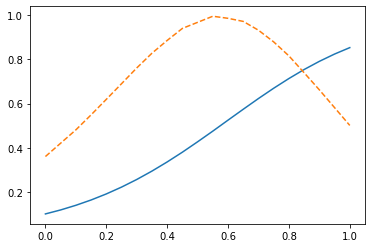

In [6]:
import matplotlib.pyplot as plt

M = 10
t = np.array([m / (M-1) for m in range(M)])
u = np.array([0 for m in range(M)])

f_lerp = Lerper(t, u, preproc=lambda x: 4*(1-x)*x)

N = 20
hmmProblem = HMMProblem(MacProb(f_lerp), [MicProb(tn, un) for tn, un in zip(t, u)])
hmmSolver = IterativeHMMSolver(FWEuler(N=N, T=1), [IdSolver(),]*M)

tSol = np.array([n/N for n in range(N+1)])
#callback = lambda sol, _: plt.plot(sol[0], sol[1])
callback = lambda x, y: None
macSol, micSol = hmmSolver.solve(hmmProblem, [tSol, tSol * 0], maxiter=100, tol=1e-2,\
                                 callback=callback, verbose=True)
                                

plt.plot(macSol[0], macSol[1])
plt.plot(macSol[0], f_lerp(macSol[0]), '--')

# Test 3:

We formulate a Multi Scale problem, from which the HMM is derived.

In [7]:
from util.plot_tools import *

class MultiScaleStokes(Problem):
    def __init__(self, floor, width, height, condition):
        self.floor = floor
        self.width = width
        self.height = height
        self.condition = condition
        pass
    
    def is_solution(self, sol: Function) -> bool:
        assert sol.space.dim == 3, "Must be 3-dim function space"
        assert type(sol.space) is HnSpace, "Must be sobolev space function"
        u = sol[0]
        p = sol[1]
        return False
        
    def to_macro_micro(self, macro_box, micro_boxes, interpolator, projector):
        pass
    
    def plot(self, **kwargs):
        x = np.linspace(0, self.width, 200)
        fx = self.floor(x)
        plt.plot(x, fx, **kwargs)
        plt.plot([x[0], x[0], x[-1], x[-1]], [fx[0], self.height, self.height, fx[-1]], **kwargs)
        pass
    

ms_stokes = MultiScaleStokes(floor=lambda x: np.sin(100*x)*0.01, width=1, height=0.4)
ms_stokes.plot(color='black')        
plt.axis("equal")
remove_axes(ax=plt.gca())

NameError: name 'Function' is not defined